In [1]:
import os
import sys
from pathlib import Path

ROOT_DIR = Path(os.getcwd()).parent.resolve()
sys.path.append(str(ROOT_DIR))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from src.config import cfg  # noqa: E402
from src.logger import get_logger  # noqa: E402

log = get_logger(__name__)

# 1. Load data

In [3]:
features_path = f"{ROOT_DIR}/{cfg['data']['features_path']}"
labels_path = f"{ROOT_DIR}/{cfg['data']['labeled_path']}"
features = pd.read_parquet(features_path)
labels   = pd.read_parquet(labels_path)

df = features.merge(labels, on="userId", how="inner")

log.info(f"Loaded dataset shape: {df.shape}")


2025-10-08 15:19:50,108 | INFO | __main__: Loaded dataset shape: (426, 37)


# 2. Prepare X, y

In [4]:
X = df.drop(columns=["userId", "churn"])
y = df["churn"].astype(int)

# Handle any non-numeric columns
X = pd.get_dummies(X, drop_first=True)

# Fill NaNs
X = X.fillna(0)

# 3. Split train / test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Scale numeric features

In [6]:
num_cols = X_train.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# 5. Train model (RandomForest)

In [7]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

# 6. Evaluate

In [8]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

log.info(f"Accuracy: {acc:.3f}")
log.info(f"ROC-AUC: {auc:.3f}")
log.info(f"\nClassification report:\n {classification_report(y_test, y_pred)}")

2025-10-08 15:19:50,237 | INFO | __main__: Accuracy: 0.965
2025-10-08 15:19:50,237 | INFO | __main__: ROC-AUC: 0.999
2025-10-08 15:19:50,239 | INFO | __main__: 
Classification report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        73
           1       1.00      0.77      0.87        13

    accuracy                           0.97        86
   macro avg       0.98      0.88      0.92        86
weighted avg       0.97      0.97      0.96        86



# 7. Feature Importance

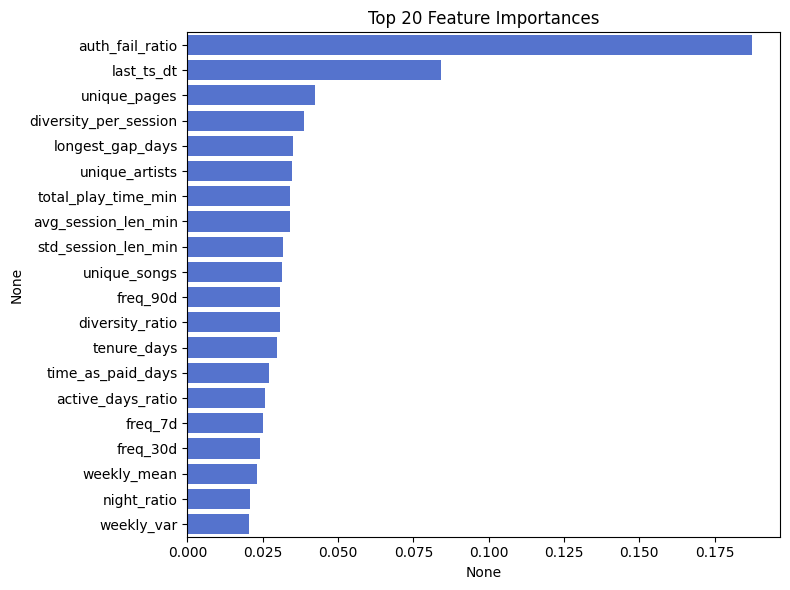

In [9]:
importances = pd.Series(model.feature_importances_, index=X_train.columns)
imp_sorted = importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
sns.barplot(x=imp_sorted, y=imp_sorted.index, color="royalblue")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

In [10]:
importances.sort_values(ascending=True)

region_ID                 0.000000e+00
region_ME                 0.000000e+00
region_MT                 0.000000e+00
session_len_change_pct    0.000000e+00
region_HI                 1.143094e-18
                              ...     
longest_gap_days          3.505060e-02
diversity_per_session     3.859297e-02
unique_pages              4.221213e-02
last_ts_dt                8.412035e-02
auth_fail_ratio           1.873480e-01
Length: 86, dtype: float64